# Grasp-and-Lift(GAL) EEG Detection
## Classification for Hand movements
- 被験者数: **12**
- 各被験者ごとの試行のデータ系列数: **8**
- 各被験者のひとつのデータ系列内の試行回数: **約30**(試行回数は各系列データごとに異なる) 

training set: 各被験者の最初の8つの試行のデータ系列<br/>
test set: 第9,10番目の試行のデータ系列<br/>

### Ivents (label columns)
各GALには、6つのイベントを検出するタスク 
(それぞれのイベントにおいて2値分類(ラベル0,1))
　
1. HandStart
1. FirstDigitTouch
1. BothStartLoadPhase
1. LiftOff
1. Replace
1. BothReleased

これらのイベントは常に同じ順序で発生する<br/>
training setには、各件名+シリーズの組み合わせごとに2つのファイル<br/>

### Data
* *_data.csvファイルには、rawの32チャネルEEG(Electroencephalography, 脳波)データ（サンプリングレート500Hz）
* *_events.csvファイルには、すべてのイベントのフレーム・ワイズ・ラベル(1の連続)が含まれる
 * 6つのラベル列は、対応するイベントが±150ms（±75フレーム）以内に発生したかどうかに応じて、ゼロまたは1のいずれか

## 目標
#### 理想: イベントの窓(フレーム・ワイズ・ラベル)全体を完璧に予測

## 注意
#### 未来データは使用できない(予測する系列の平均などはとれない)

## μ律動
7～12Hzのアーチ状の連続した波で，中心・頭頂部に一側性または両側性に出現する．
開眼時には減衰しないが，手を握るなどの運動や感覚刺激により抑制される

In [1]:
from IPython.display import HTML
HTML(r'<iframe width="560" height="315" src="https://www.youtube.com/embed/y3_Izuop2gY" frameborder="0" allowfullscreen></iframe>')

# パッケージの準備

In [2]:
import numpy as np
import scipy
from scipy import stats
import scipy.signal as signal
from scipy.interpolate import interp1d
from scipy import fftpack
import pandas as pd
# classifier
from classifierRandomForest import classifyRandomForest
from classifierSVC import classifySVC
from classifierXGB import classifyXGB
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

from glob import glob
import os

from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
%matplotlib inline

# evaluation
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

# score
from sklearn.metrics import roc_auc_score
from joblib import Parallel, delayed



from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import GridSearchCV

import itertools

/Users/motofumishishikura/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# 関数の準備

In [3]:
### データの読み込み ###

def prepare_data_train(fname):
    """ 訓練データの読み込み """
    # EEGデータ読み込み
    data = pd.read_csv(fname)
    # fnameイベントファイルの名前に変換
    events_fname = fname.replace('_data','_events')
    # イベントデータの読み込み
    labels= pd.read_csv(events_fname)
    clean=data.drop(['id' ], axis=1)#id列を削除
    labels=labels.drop(['id' ], axis=1)#id列を削除
    return  clean,labels

def prepare_data_test(fname):
    """ テストデータの読み込み """
    # EEGデータの読み込み
    data = pd.read_csv(fname)
    return data

In [4]:
### 前処理 ###

def preprocess_median_filter(X, kernel):
    """ Median filter"""
    X_m = signal.medfilt(X, kernel_size=kernel)
    return X_m

def preprocess_fir_filter(X, fc):
    """ FIR filter """
    fs = 500
    nyq = fs / 2.0  # ナイキスト周波数

    # フィルタの設計
    # ナイキスト周波数が1になるように正規化
    fe = fc / nyq      # カットオフ周波数1
    numtaps = 15          # フィルタ係数（タップ）の数（要奇数）

    b = scipy.signal.firwin(numtaps, fe) # Low-pass

    # FIRフィルタをかける
    X_FIR = scipy.signal.lfilter(b, 1, X)
    return X_FIR

def cut_off(X, fs):
    """ FFT処理後に高周波を取り除く"""
    # fs: カットオフ周波数[Hz]
    # 時系列のサンプルデータ作成
    n = X.shape[0]                         # データ数
    dt = 0.002                       # サンプリング間隔
    f = 500                           # 周波数

    # FFT 処理と周波数スケールの作成
    X_f = fftpack.fft(X)/(n/2)
    freq = fftpack.fftfreq(n, dt)

    # フィルタ処理
    # ここではカットオフ周波数以上に対応するデータを 0 にしている                          
    X_f2 = np.copy(X_f)
    X_f2[(freq > fs)] = 0
    X_f2[(freq < 0)] = 0

    # 逆 FFT 処理
    # FFT によるフィルタ処理では虚数部が計算されることがあるため
    # real 関数が必要(普段は必要ない)
    X_prep = np.real(fftpack.ifft(X_f2)*n)
    
    return X_prep


def data_preprocess_train(X):
    scaler= StandardScaler()
    X_prep = scaler.fit_transform(X)
#     X_prep = preprocess_fir_filter(X_prep, 100.0)
#     X_prep = cut_off(X, 50.0)

    #ここで他のpreprocessingを追加
    return X_prep

def data_preprocess_test(X):
    scaler= StandardScaler()
    X_prep = scaler.transform(X)
    #ここで他のpreprocessingを追加
    return X_prep

In [5]:
### Signal -> Power spectrum ###

def spectrum (vector):
    ''' raw EEG dataベクトルのpower spectrum '''
    A = np.fft.fft(vector)# /len(vector)
    ps = np.abs(A)**2
    # 正のpower spectrum
    ps = ps[:len(ps)//2]
    return ps

In [6]:
def run_kfold(clf):
    kf = KFold(n_splits=10)
    outcomes = []
    fold = 0
    for train_index, test_index in kf.split(X_Oz_f):
        fold += 1
        X_train, X_test = X_Oz_f[train_index], X_Oz_f[test_index]
        y_train, y_test = y_f_handstart[train_index], y_f_handstart[test_index]
        clf.fit(X_train, y_train)
        predictions = clf.predict(X_test)
        accuracy = accuracy_score(y_test, predictions)
        outcomes.append(accuracy)
        print("Fold {0} accuracy: {1}".format(fold, accuracy))
    mean_outcome = np.mean(outcomes)
    print("Mean Accuracy: {0}".format(mean_outcome))

フィルタ処理はどうしたらいいかわからない

## 6 Ivents(label columns):

1. HandStart
1. FirstDigitTouch
1. BothStartLoadPhase
1. LiftOff
1. Replace
1. BothReleased

In [7]:
cols = ['HandStart','FirstDigitTouch',
        'BothStartLoadPhase','LiftOff',
        'Replace','BothReleased']

## 12 Subjects

In [8]:
#被験者数
subjects = range(1,13)
ids_tot = []
pred_tot = []

# 運動の初動(HandStart)を予測


- EEGで運動の初動を予測
- 脳の特徴: 機能局在
 - Channelsの選択
 - 試行(開始，終了)はLEDによって指示→視覚情報処理(RetinaからVisual cortexへ)→Visual cortex付近のEEGに運動の初動の情報が含まれているのではないか
 - O1, O2, Oz: V1
 - F3, F4: Primary motor cortex: M1
 - <img src="image/EEG_Electrode_Numbering.jpg">
- EEGの特徴:
 - Since EEG activity is associated with frequencies from 1-40 Hz, it is generally presumed that this range contains the majority of relevant signal.
 - This frequency range can be polluted with non-neural signals (Ball et al., 2009)
 - EEGの特徴より，40Hzまでの特徴空間
- Reaction timeは視覚刺激の検出では180から200msec(心理物理実験により) (Wong et al., 2015)
 - HandStartの1000msec前からリアルタイムまでのEEG信号のパワースペクトラムを特徴とする
 - DFTの性質上周波数スペクトル間隔はPointsの数に依存するため大きく取りたい
 - <img src="image/RTdistributions.png">


## Ex1:
- Channel: Oz
- Subject: 1
- Series: 1
### ACC: 0.956

## Ex2:
- Channel: Oz
- Subject: 1
- Series: 1~8
### ACC: 0.973

## Ex3:
- Channel: C1, C2, P3, Pz, P4, PO7, Oz, PO8
- Subject: 1
- Series: 1~8

## Ex4:
- Channel: C1, C2, P3, Pz, P4, PO7, Oz, PO8
- Subject: 1~12
- Series: 1~8

## Ex1: Oz channel(subject1,series1)のデータ
### Visual cortexあたり
- 実験では，オブジェクトのライトが点灯して動作をスタートさせる(handstart)ため，視覚野あたりのEEGデータから予測できるのではないか

### subject1,series1のデータ取得

In [9]:
fnames = glob('input/train/subj1_series1_data.csv')
print(fnames)
X = []
y = []
for fname in fnames:
    # 訓練データの読み込み
    data,labels = prepare_data_train(fname)
    # すべての系列データ(1-8)
    X.append(data)
    y.append(labels)

# 1次元のlistにする
X = pd.concat(X)
y = pd.concat(y)

['input/train/subj1_series1_data.csv']


In [10]:
#numpy arrayにする   
X = np.asarray(X.astype(float))
y = np.asarray(y.astype(float))

- 119,496Points/500Hz ≒ 240sec 
- 32 channels

In [11]:
print(X.shape)
print(y.shape)

(119496, 32)
(119496, 6)


### Oz channelのデータ取得

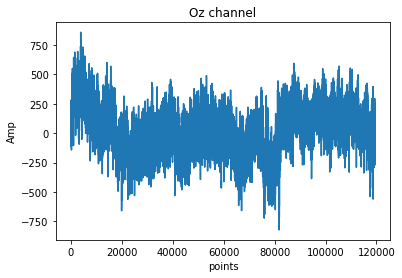

In [12]:
fig, ax = plt.subplots()

X_Oz = X[:, 29]
ax.plot(X_Oz)
ax.set_title('Oz channel')
plt.xlabel("points")
plt.ylabel("Amp")
plt.show()

# 特徴抽出

## Remove DC component -> DFT -> Power -> cut-off

### Remove DC component

#### 1sec before the HandStart time

In [13]:
# print(y[0].index())
y_list = y[:, 0].tolist()
y_list.index(1)

1068

In [14]:
t_handstart = y_list.index(1)
# remove DC component
X_Oz_m_500 = X_Oz[range(t_handstart,t_handstart+500)] - np.mean(X_Oz[range(t_handstart,t_handstart+500)])
X_Oz_m_500_med = preprocess_median_filter(X_Oz_m_500, 3)

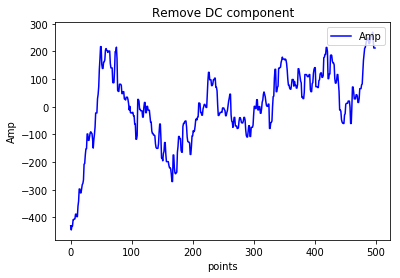

In [15]:
plt.figure()
plt.plot(X_Oz_m_500_med, "b", label="Amp")
plt.axis("tight")
plt.legend(loc="upper right")
plt.title("Remove DC component")
plt.xlabel("points")
plt.ylabel("Amp")
plt.show()

### DFT->Power spectrum

500Hz, 1000Points → 0.5Hz間隔周波数スペクトラム

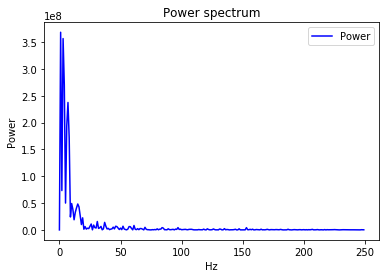

In [16]:
X_Oz_f = spectrum(X_Oz_m_500) # 1sec
plt.figure()
plt.plot(X_Oz_f, "b", label="Power")
plt.axis("tight")
plt.title("Power spectrum")
plt.legend(loc="upper right")
plt.xlabel("Hz")
plt.ylabel("Power")
plt.show()

### cut-off

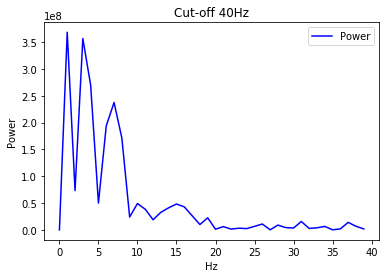

In [17]:
# powerの配列の要素数+1
X_Oz_f_100 = np.arange(1,len(X_Oz_f)+1)
# 1D補間法
f = interp1d(X_Oz_f_100,X_Oz_f)#/np.sum(ps))
X_Oz_f_100 = f(np.arange(1, 40+1))
    
plt.figure()
plt.plot(X_Oz_f_100, "b", label="Power")
plt.axis("tight")
plt.legend(loc="upper right")
plt.title("Cut-off 40Hz")
plt.xlabel("Hz")
# plt.xticks([10, 20, 30, 40, 50, 60, 70, 80], [5, 10, 15, 20, 25, 30, 35, 40])
plt.ylabel("Power")
plt.show()

### Standardize features by removing the mean and scaling to unit variance

In [22]:
X_Oz_f_s = data_preprocess_train(X_Oz_f_100.reshape((-1,1)))

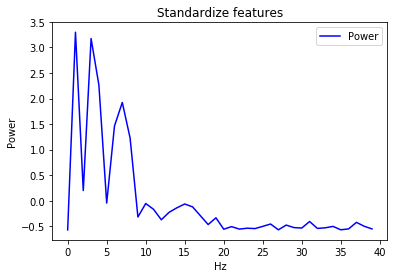

In [23]:
plt.figure()
plt.plot(X_Oz_f_s, "b", label="Power")
plt.axis("tight")
plt.legend(loc="upper right")
plt.title("Standardize features")
plt.xlabel("Hz")
# plt.xticks([10, 20, 30, 40, 50, 60, 70, 80], [5, 10, 15, 20, 25, 30, 35, 40])
plt.ylabel("Power")
plt.show()

### binning

In [ ]:
import numpy
# data = numpy.random.random(100)
bins = numpy.linspace(0, 1, 10)
digitized = numpy.digitize(X_Oz_f_100, bins)
bin_means = [data[digitized == i].mean() for i in range(1, len(bins))]

In [34]:
import numpy
data = numpy.random.random(100)
bins = numpy.linspace(0, 1, 10)
digitized = numpy.digitize(data, bins)
bin_means = [data[digitized == i].mean() for i in range(1, len(bins))]

## 時刻[t-2, t]secのPower spectraを特徴ベクトルとして時刻tのイベントを推定

In [63]:
point_cutoff = 40 + 1 #cutoff-frequency[Hz] * 2 + 1
X_Oz_f = np.empty((0,point_cutoff))
y_f_handstart = np.empty((0))

for stride in range(500,len(X_Oz),3):
    """ stride:3, 150msec, 500Hz-> 1.5*500/3個の連続する1 """
    X_Oz_r = X_Oz[stride-500:stride]
    X_Oz_m = X_Oz_r - np.mean(X_Oz_r) # remove DC component
    dft_X_Oz_f = np.array(spectrum(X_Oz_m)[:point_cutoff]).reshape((1,-1)) # Power
    X_Oz_f = np.append(X_Oz_f, dft_X_Oz_f, axis=0)
    y_f_handstart = np.append(y_f_handstart, y[stride, 0])

In [64]:
print(X_Oz_f.shape)
print(y_f_handstart.shape)

(39666, 41)
(39666,)


### Standardize features by removing the mean and scaling to unit variance

In [65]:
X_Oz_f_s = data_preprocess_train(X_Oz_f)

### Cross-validationを用いたAccuracyによる予測能の比較

In [70]:
clf = LogisticRegression()
scores_LR = cross_val_score(estimator=clf,
                         X=X_Oz_f,
                         y=y_f_handstart,
                         cv=10,
                         n_jobs=1)

In [71]:
print('CV accuracy scores: %s' % scores_LR)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores_LR), np.std(scores_LR)))

CV accuracy scores: [ 0.95714646  0.95714646  0.95311318  0.95714646  0.95639022  0.95714646
  0.95713565  0.95511851  0.95713565  0.95713565]
CV accuracy: 0.956 +/- 0.001


In [ ]:
# print('CV accuracy scores: %s' % scores_XGB)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores_XGB), np.std(scores_XGB)))

In [35]:
clf = classifyXGB(X_Oz_f, y_f_handstart)
run_kfold(clf)

Fold 1 accuracy: 0.9495840685656668
Fold 2 accuracy: 0.96218805142425
Fold 3 accuracy: 0.9480715906226368
Fold 4 accuracy: 0.96218805142425
Fold 5 accuracy: 0.96218805142425
Fold 6 accuracy: 0.9495840685656668
Fold 7 accuracy: 0.962178517397882
Fold 8 accuracy: 0.9495713565305093
Fold 9 accuracy: 0.962178517397882
Fold 10 accuracy: 0.962178517397882
Mean Accuracy: 0.9569910790750876


In [ ]:
from classifierSVC import classifySVC
from sklearn.svm import SVC
clf = SVC()
scores_SVC = cross_val_score(estimator=clf,
                         X=X_Oz_f,
                         y=y_f_handstart,
                         cv=10,
                         n_jobs=1)

In [ ]:
print('CV accuracy scores: %s' % scores_SVC)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores_SVC), np.std(scores_SVC)))

In [ ]:
clf = classifySVC(X_Oz_f, y_f_handstart)
run_kfold(clf)

## Ex2:Oz channel(subject1,series 1~8)のデータ
- 実験の数を増やしてみる(time series 1~8を用いる)

### subject1,series1~9のデータ取得

In [6]:
subject = 1
series = range(1,9)
y_raw= []
raw = []
sequence = []
################ READ DATA ################################################
for ser in series:
    fname = 'input/train/subj%d_series%d_data.csv' % (subject,ser)
    data,labels = prepare_data_train(fname)
    raw.append(data)
    y_raw.append(labels)
    sequence.extend([ser]*len(data))

In [7]:
X = pd.concat(raw)
y = pd.concat(y_raw)
#transform in numpy array
#transform train data in numpy array
X = np.asarray(X.astype(float))
y = np.asarray(y.astype(float))
sequence = np.asarray(sequence)
#     print(sequence.shape, y.shape, X.shape)

- 1,422,392Points/500Hz ≒ 2845sec 
- 32 channels

In [9]:
print(X.shape)
print(y.shape)

(1422392, 32)
(1422392, 6)


### Oz channelのデータ取得

In [10]:
X_Oz = X[:, 29] # choose Oz channel
point_cutoff = 80 + 1 #cutoff-frequency[Hz] * 2 + 1
X_Oz_f = np.empty((0,point_cutoff))
y_f_handstart = np.empty((0))

In [14]:
for stride in range(500,len(X_Oz),3):
    """ stride:3, 150msec, 500Hz-> 1.5*500/3個の連続する1 """
    X_Oz_r = X_Oz[stride-500:stride]
    X_Oz_m = X_Oz_r - np.mean(X_Oz_r) # remove DC component
    dft_X_Oz_f = np.array(spectrum(X_Oz_m)[:point_cutoff]).reshape((1,-1)) # Power
    X_Oz_f = np.append(X_Oz_f, dft_X_Oz_f, axis=0)
    y_f_handstart = np.append(y_f_handstart, y[stride, 0])

KeyboardInterrupt: 

In [ ]:
print(X_Oz_f.shape)
print(y_f_handstart.shape)

In [ ]:
################ Train classifiers ########################################
cv = LeaveOneGroupOut()
cv.get_n_splits(groups=sequence)
pred = np.empty(X.shape[0])

for train, test in cv.split(X, y, sequence):
    X_train = X[train]
    X_test = X[test]
    y_train = y[train]
    #apply preprocessing
    X_train = data_preprocess_train(X_train)
    X_test = data_preprocess_test(X_test)
    clfs = Parallel(n_jobs=6)(delayed(fit)(X_train[::subsample,:],y_train[::subsample,i]) for i in range(6))
    preds = Parallel(n_jobs=6)(delayed(predict)(clfs[i],X_test) for i in range(6))
    pred[test,:] = np.concatenate(preds,axis=1)

# get AUC
auc = roc_auc_score(y[:],pred[:])    
print("subject", subject)
print(auc)

#### ACC

In [1]:
acc_ex2 = [0.9726,0.9726,0.9726,0.9726,0.9726,0.9726,0.9726,0.9726,0.9726,0.9726]

## Ex3:C1, C2, P3, Pz, P4, PO7, Oz, PO8 channel(subject1,series 1~8)のデータ
- Channels位置は C1, C2, P3, Pz, P4, PO7, Oz, PO8 の 8 カ所

# 訓練過程 

# 交差検証法を用いたAUC(Area Under the Curve)による予測能の比較
- AUC: ROC曲線(Receiver Operatorating Characteristic curve、受信者動作特性曲線)の面積
- 混合行列を定量的に比較し，予測能を判断するもの

In [ ]:
def fit(X,y):
    # Do here you training
    clf = LogisticRegression()
    clf.fit(X,y)
    return clf

def predict(clf,X):
    # do here your prediction
    preds = clf.predict_proba(X)
    return np.atleast_2d(preds[:,clf.classes_==1])
    
#series used for CV
series = range(1,9)

## Logistic Regression

In [ ]:
#######number of subjects###############
subjects = range(1,9)
auc_tot = []
pred_tot = []
y_tot = []
###loop on subjects and 8 series for train data + 2 series for test data
for i, subject in enumerate(subjects):
    y_raw= []
    raw = []
    sequence = []
    ################ READ DATA ################################################
    for ser in series:
        fname =  'input/train/subj%d_series%d_data.csv' % (subject,ser)
        data,labels=prepare_data_train(fname)
        raw.append(data)
        y_raw.append(labels)
        sequence.extend([ser]*len(data))

    X = pd.concat(raw)
    y = pd.concat(y_raw)
    #transform in numpy array
    #transform train data in numpy array
    X = np.asarray(X.astype(float))
    y = np.asarray(y.astype(float))
    sequence = np.asarray(sequence)
#     print(sequence.shape, y.shape, X.shape)


    ################ Train classifiers ########################################
    cv = LeaveOneGroupOut()
    cv.get_n_splits(groups=sequence)
    pred = np.empty((X.shape[0],6))

    for train, test in cv.split(X, y, sequence):
        X_train = X[train]
        X_test = X[test]
        y_train = y[train]
        #apply preprocessing
        X_train = data_preprocess_train(X_train)
        X_test = data_preprocess_test(X_test)
        clfs = Parallel(n_jobs=6)(delayed(fit)(X_train[::subsample,:],y_train[::subsample,i]) for i in range(6))
        preds = Parallel(n_jobs=6)(delayed(predict)(clfs[i],X_test) for i in range(6))
        pred[test,:] = np.concatenate(preds,axis=1)
    pred_tot.append(pred)
    y_tot.append(y)
    # get AUC
    auc = [roc_auc_score(y[:,i],pred[:,i]) for i in range(6)]     
    auc_tot.append(auc)
    print("subject", i + 1)
    print(auc)

pred_tot = np.concatenate(pred_tot)
y_tot = np.concatenate(y_tot)
global_auc = [roc_auc_score(y_tot[:,i],pred_tot[:,i]) for i in range(6)]

print('Global AUC : %.4f' % np.mean(global_auc))

auc_tot = np.asarray(auc_tot)
results = pd.DataFrame(data=auc_tot, columns=cols, index=subjects)
results.to_csv('results_cv_auc.csv')

plt.figure(figsize=(4,3))
results.mean(axis=1).plot(kind='bar')
plt.xlabel('Subject')
plt.ylabel('AUC')
plt.title('CV auc for each subject')
plt.savefig('cross_val_auc_subject.png' ,bbox_inches='tight')

plt.figure(figsize=(4,3))
results.mean(axis=0).plot(kind='bar')
plt.ylabel('AUC')
plt.title('CV auc for each class')
plt.savefig('cross_val_auc_class.png' ,bbox_inches='tight')

## Kernel SVM

## XGBoost

# やること
## 前処理
- ローバスフィルタ，メディアンフィルタとか->うまくいかない
- ダウンサンプリングとか->うまくいかない
- ブリンクを取って，加算平均とか

## 学習
- 学習器の比較
 - kernel SVM
 - EXBoost
 - DNN

## 可視化
- データ可視化
- 結果可視化